In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, BasicAer, Aer
from qiskit.algorithms.optimizers import COBYLA
from concurrent.futures import ThreadPoolExecutor
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms import VQE

def exact_solver(problem, converter):
    print(problem)
    print(converter)
    #print("I AM HERE11")
    solver = NumPyMinimumEigensolverFactory()
    #print("I AM HERE12")
    calc = GroundStateEigensolver(converter, solver)
    #print("I AM HERE13")
    #result = calc.solve(problem)
    #print("I AM HERE14")
    return 0

def get_qubit_op(coordinates):
    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0],coordinates[1],0]],
            ["H", [coordinates[2],coordinates[3],0]],
            ["H", [coordinates[4],coordinates[5],0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=1,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    #hamiltonian = electronic_energy.second_q_ops()["ElectronicEnergy"]
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm', shots=1028):
    
    
    if simulator == 'exact':
        backend = Aer.get_backend('qasm_simulator')
        #backend.set_options(max_job_size=1,executor=euler_client)
        quantum_instance = QuantumInstance(backend,shots=shots)
        optimizer = COBYLA(maxiter=400)
    elif simulator == 'qasm':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = COBYLA(maxiter=400)
    else:
        print('Error: simulator should be qasm or exact!')
     
    #result = exact_solver(problem,converter)
    
    #print(num_orb)
    #print(num_part)
    num_orb = 4
    init_state = HartreeFock(num_orb, num_part, converter)
    
    #print(init_state)
    #print(op)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 

    vqe_result = vqe.compute_minimum_eigenvalue(op)

    min_eng = vqe_result.eigenvalue

    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    #euler_client.close()
    print('ground state energy: ',min_eng)
    
    return vqe_ground, min_eng

In [2]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
m = 16 #times which we calculate the force


from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import time #to see which part of code takes the longest
import multiprocessing

#task to calculate expectation value
def task1(string, q_instance, psi_0):

    Obs = PauliOp(Pauli(string))
    measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    E = sampler.eval().real
        
    return E

#task to calculate operator from coordinates
def task2(coordinates):
    
    #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
    (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0])
    #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
    (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[1])

    rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
    qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
    qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
    op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
                    
    op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
    #construct dict from list
    op_dict = {}
    for (PauliString,coeff) in op_list:

        if PauliString in op_dict:
            op_dict[PauliString] += coeff
        else:
            op_dict[PauliString] = coeff
    
    return op, op_dict
 
def parallel_operators(coordinates):
    
    coordinate_list = []
    for i in range(len(coordinates)):
        coordinate_list.append([coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:],coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:]])
    
    with multiprocessing.Pool() as pool:
         ops,op_coeffs = zip(*pool.map(task2, coordinate_list))

    return ops, op_coeffs

def sequential_operators(coordinates):
    ops = []
    op_coeffs = []
    
    for i in range(len(coordinates)):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        ops.append(op)
        op_coeffs.append(op_dict)
    #print(ops)
    return ops, op_coeffs

def parallel_expectations(exp_dict, op_set, q_instance, psi_0):

    triples = []
    for op in op_set:
        triple = (op,q_instance,psi_0)
        triples.append(triple)

    Es = 0
    with multiprocessing.Pool() as pool:
        Es = pool.starmap(task1, triples)

    for i in range(len(Es)):
        exp_dict[triples[i][0]]=Es[i]

    return 0

def sequential_expectations(exp_dict, op_set, q_instance, psi_0):

    for pauli_string in op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        exp_dict[pauli_string] = E

    return 0

def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator,shots=shots)
    
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator)
    finish = time.time()
    print("Took " + str(finish - start) + " seconds to find ground state")
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=128)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    vars = []
    #loop over particles
    start = time.time()
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
        Obs_var = Obs*Obs
        print("PRIMITIVE LIST")
        print(Obs_var.primitive.to_list())
        nuc = rep_eng_plus - rep_eng_minus
        #Obs_squared = Obs * Obs
       
        #get the expectation value Ã‚Â¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        measurable_expression_var = StateFn(Obs_var, is_measurement=True).compose(psi_0)
        #measurable_expression_var =  StateFn(Obs_squared, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)
        expectation_var = PauliExpectation().convert(measurable_expression_var)
 
        #expectation_var = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)
        sampler_var = CircuitSampler(q_instance).convert(expectation_var)
        #sampler_var = CircuitSampler(q_instance).convert(expectation) 

        f = sampler.eval().real + nuc
        ff = sampler_var.eval().real + 2*sampler.eval().real*nuc +nuc**2 +(sampler.eval().real)**2
        print(ff)
        #print(sampler_var.eval())
        #variance = sampler_var.eval().real - f^2
        forces.append(f*Ha*(1/(2*dR*angst)))
        vars.append(ff*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces, vars


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 128):
  
    
    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator')
            #backend.set_options(max_job_size=1, executor = euler_client)
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)   
    
    start = time.time()
    

    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    
    end = time.time()
    
    
    time_psi_0 = end - start
    #print("Took " + str(time_psi_0) + " s to calculate the ground state")
    forces = np.zeros(num_coord)
    coordinates = coordinates.tolist()
    
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons)
    #replace parallel_ with sequential_ to see effect of parallelization
    force_ops,force_op_coeffs = parallel_operators(coordinates)
    
    #print(force_ops)
    P1 = force_ops[0]
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
        
            P_prod = P1@P1
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    start = time.time()
    exp_dict = {} # dictionary with relevant expectation values
        
    #switch between parallel_ and sequential_ to see the effect
    parallel_expectations(exp_dict,pauli_op_set,q_instance,psi_0)

    
    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):

            Pij = force_ops[i]@force_ops[j]
            Pij_list = Pij.primitive.to_list()

            #add product expectation 
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
                    #subtract 
            COV[i,j] -= forces[i]*forces[j]

            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]
    end = time.time()
    
    time_cov = end - start

    print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    #print(COV)
    
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2

In [3]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))


def main():
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    #initial velocity of atoms
    v_init_0 = np.array([0,0])
    v_init_1 = np.array([0,0])
    v_init_2 = np.array([0,0])

    v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

    #distances between atoms
    d = 0.8

    #initial positions of atoms, arrangement = equilateral triangle
    init_pos0 = np.array([0,0])
    init_pos1 = np.array([d,0])
    init_pos2 = np.array([d/2,np.sqrt(3)/2*d])
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)

    #integrator timesteps
    times = np.arange(0*femto, 100.0*femto, dt)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
    delta = 0.1*dt
    #hold v_next
    v_next = None
    
    simulator = 'qasm'

    for time in tqdm(times, desc='Progress: '):
        
        r = coords[-1]
        
        (forces,COV) = calc_force_and_cov(coords[-1],simulator = simulator, shots = 2056)
        
        if time == 0:

            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:

            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    return (distance01,distance02,distance12,times) 

Progress:   0%|          | 0/500 [00:00<?, ?it/s]/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


ground state energy:  (-3.2094852397386386+0j)


Progress:   0%|          | 1/500 [00:09<1:19:31,  9.56s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 2.05s, Calculate Covariance - 0.44s
ground state energy:  (-3.199390676903378+0j)


Progress:   0%|          | 2/500 [00:18<1:14:42,  9.00s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 2.01s, Calculate Covariance - 0.49s
ground state energy:  (-3.179925845655604+0j)


Progress:   1%|          | 3/500 [00:30<1:26:31, 10.45s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 8.09s, Calculate Pauli Expectation Values - 2.18s, Calculate Covariance - 0.84s
ground state energy:  (-3.152569288229073+0j)


Progress:   1%|          | 4/500 [00:39<1:21:54,  9.91s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.78s
ground state energy:  (-3.118558089408064+0j)


Progress:   1%|          | 5/500 [00:48<1:18:21,  9.50s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-3.0794961663490192+0j)


Progress:   1%|          | 6/500 [00:56<1:15:55,  9.22s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.79s
ground state energy:  (-3.037160332941597+0j)


Progress:   1%|▏         | 7/500 [01:08<1:21:32,  9.92s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 8.23s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.78s
ground state energy:  (-2.9929107931190897+0j)


Progress:   2%|▏         | 8/500 [01:16<1:18:11,  9.54s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.78s
ground state energy:  (-2.948078345979363+0j)


Progress:   2%|▏         | 9/500 [01:25<1:15:28,  9.22s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.64s, Calculate Covariance - 0.78s
ground state energy:  (-2.903636321450797+0j)


Progress:   2%|▏         | 10/500 [01:34<1:14:33,  9.13s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.77s
ground state energy:  (-2.860518026162208+0j)


Progress:   2%|▏         | 11/500 [01:42<1:12:37,  8.91s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.83s
ground state energy:  (-2.8195117664986755+0j)


Progress:   2%|▏         | 12/500 [01:51<1:12:24,  8.90s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.79s
ground state energy:  (-2.7809856088798783+0j)


Progress:   3%|▎         | 13/500 [02:00<1:12:04,  8.88s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.78s
ground state energy:  (-2.7453506560909378+0j)


Progress:   3%|▎         | 14/500 [02:09<1:11:03,  8.77s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.78s
ground state energy:  (-2.712831580522117+0j)


Progress:   3%|▎         | 15/500 [02:19<1:14:11,  9.18s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.29s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 1.09s
ground state energy:  (-2.683533758732317+0j)


Progress:   3%|▎         | 16/500 [02:28<1:14:30,  9.24s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 2.02s, Calculate Covariance - 0.92s
ground state energy:  (-2.657628497278906+0j)


Progress:   3%|▎         | 17/500 [02:38<1:14:55,  9.31s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 2.04s, Calculate Covariance - 0.85s
ground state energy:  (-2.635131503533952+0j)


Progress:   4%|▎         | 18/500 [02:47<1:14:42,  9.30s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.97s
ground state energy:  (-2.616014965094537+0j)


Progress:   4%|▍         | 19/500 [02:56<1:14:06,  9.24s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.77s
ground state energy:  (-2.6002900909400406+0j)


Progress:   4%|▍         | 20/500 [03:06<1:15:37,  9.45s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 1.98s, Calculate Covariance - 0.98s
ground state energy:  (-2.5879292872297337+0j)


Progress:   4%|▍         | 21/500 [03:16<1:16:56,  9.64s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 6.33s, Calculate Pauli Expectation Values - 2.03s, Calculate Covariance - 0.83s
ground state energy:  (-2.5788606677027777+0j)


Progress:   4%|▍         | 22/500 [03:28<1:22:38, 10.37s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 8.58s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.77s
ground state energy:  (-2.573055044914408+0j)


Progress:   5%|▍         | 23/500 [03:40<1:25:52, 10.80s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 7.85s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.91s
ground state energy:  (-2.5704414557045716+0j)


Progress:   5%|▍         | 24/500 [03:49<1:22:46, 10.43s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 2.04s, Calculate Covariance - 0.86s
ground state energy:  (-2.5709644892385315+0j)


Progress:   5%|▌         | 25/500 [03:58<1:19:13, 10.01s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.8s
ground state energy:  (-2.574643782898661+0j)


Progress:   5%|▌         | 26/500 [04:11<1:25:14, 10.79s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 8.91s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 0.83s
ground state energy:  (-2.5813935780658954+0j)


Progress:   5%|▌         | 27/500 [04:20<1:21:24, 10.33s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.97s, Calculate Covariance - 0.77s
ground state energy:  (-2.5911759785618496+0j)


Progress:   6%|▌         | 28/500 [04:29<1:17:50,  9.90s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 0.81s
ground state energy:  (-2.6040209441534907+0j)


Progress:   6%|▌         | 29/500 [04:38<1:16:06,  9.70s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 1.03s
ground state energy:  (-2.6198262857807446+0j)


Progress:   6%|▌         | 30/500 [04:48<1:15:02,  9.58s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.81s
ground state energy:  (-2.6386607129524755+0j)


Progress:   6%|▌         | 31/500 [04:57<1:13:47,  9.44s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.84s
ground state energy:  (-2.6603178030656007+0j)


Progress:   6%|▋         | 32/500 [05:06<1:13:24,  9.41s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 0.94s
ground state energy:  (-2.6846696106007797+0j)


Progress:   7%|▋         | 33/500 [05:15<1:11:31,  9.19s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.82s
ground state energy:  (-2.7114989243381107+0j)


Progress:   7%|▋         | 34/500 [05:24<1:11:23,  9.19s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.98s, Calculate Covariance - 0.86s
ground state energy:  (-2.7407332653623504+0j)


Progress:   7%|▋         | 35/500 [05:33<1:11:49,  9.27s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.99s
ground state energy:  (-2.772024301909446+0j)


Progress:   7%|▋         | 36/500 [05:43<1:13:03,  9.45s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 1.11s
ground state energy:  (-2.8052074796949635+0j)


Progress:   7%|▋         | 37/500 [05:52<1:11:37,  9.28s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.78s
ground state energy:  (-2.839779651417877+0j)


Progress:   8%|▊         | 38/500 [06:02<1:11:50,  9.33s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.78s
ground state energy:  (-2.8753316479768185+0j)


Progress:   8%|▊         | 39/500 [06:11<1:10:35,  9.19s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.88s
ground state energy:  (-2.911236193790358+0j)


Progress:   8%|▊         | 40/500 [06:20<1:10:49,  9.24s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.83s
ground state energy:  (-2.9470790696847513+0j)


Progress:   8%|▊         | 41/500 [06:28<1:07:35,  8.84s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 4.63s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.8s
ground state energy:  (-2.9816370339685516+0j)


Progress:   8%|▊         | 42/500 [06:37<1:07:28,  8.84s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.78s
ground state energy:  (-3.0142408161576735+0j)


Progress:   9%|▊         | 43/500 [06:46<1:07:53,  8.91s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.82s
ground state energy:  (-3.0441426476514613+0j)


Progress:   9%|▉         | 44/500 [06:54<1:07:26,  8.87s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.77s
ground state energy:  (-3.070252300397937+0j)


Progress:   9%|▉         | 45/500 [07:03<1:06:55,  8.83s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.77s
ground state energy:  (-3.09153143063072+0j)


Progress:   9%|▉         | 46/500 [07:17<1:18:58, 10.44s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 10.76s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.78s
ground state energy:  (-3.1070047878033646+0j)


Progress:   9%|▉         | 47/500 [07:26<1:14:48,  9.91s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 2.04s, Calculate Covariance - 0.77s
ground state energy:  (-3.116196913902129+0j)


Progress:  10%|▉         | 48/500 [07:35<1:11:44,  9.52s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.77s
ground state energy:  (-3.1188420669360997+0j)


Progress:  10%|▉         | 49/500 [07:43<1:09:45,  9.28s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.78s
ground state energy:  (-3.114977809007232+0j)


Progress:  10%|█         | 50/500 [07:52<1:08:08,  9.09s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 2.05s, Calculate Covariance - 0.78s
ground state energy:  (-3.104771960265619+0j)


Progress:  10%|█         | 51/500 [08:00<1:06:32,  8.89s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 4.95s, Calculate Pauli Expectation Values - 2.05s, Calculate Covariance - 0.77s
ground state energy:  (-3.0888409788431517+0j)


Progress:  10%|█         | 52/500 [08:10<1:07:15,  9.01s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 0.79s
ground state energy:  (-3.0677332349587716+0j)


Progress:  11%|█         | 53/500 [08:19<1:06:32,  8.93s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.85s
ground state energy:  (-3.042434835099672+0j)


Progress:  11%|█         | 54/500 [08:28<1:07:16,  9.05s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 2.08s, Calculate Covariance - 1.03s
ground state energy:  (-3.0139812113480864+0j)


Progress:  11%|█         | 55/500 [08:37<1:06:35,  8.98s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.77s
ground state energy:  (-2.9833553650874394+0j)


Progress:  11%|█         | 56/500 [08:45<1:05:13,  8.81s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.76s
ground state energy:  (-2.9514720414245668+0j)


Progress:  11%|█▏        | 57/500 [08:54<1:05:39,  8.89s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 2.02s, Calculate Covariance - 0.76s
ground state energy:  (-2.91904366390449+0j)


Progress:  12%|█▏        | 58/500 [09:03<1:05:35,  8.90s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 2.03s, Calculate Covariance - 0.83s
ground state energy:  (-2.8869649533915203+0j)


Progress:  12%|█▏        | 59/500 [09:12<1:05:07,  8.86s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.13s
ground state energy:  (-2.855699637161096+0j)


Progress:  12%|█▏        | 60/500 [09:21<1:06:22,  9.05s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.825724075028646+0j)


Progress:  12%|█▏        | 61/500 [09:30<1:05:35,  8.96s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.16s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.95s
ground state energy:  (-2.7975688860202212+0j)


Progress:  12%|█▏        | 62/500 [09:39<1:05:35,  8.99s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.79s
ground state energy:  (-2.7714972709645838+0j)


Progress:  13%|█▎        | 63/500 [09:49<1:06:30,  9.13s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.03s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.78s
ground state energy:  (-2.748359850643312+0j)


Progress:  13%|█▎        | 64/500 [09:58<1:07:49,  9.33s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.33s, Calculate Pauli Expectation Values - 2.02s, Calculate Covariance - 0.77s
ground state energy:  (-2.7277258200072496+0j)


Progress:  13%|█▎        | 65/500 [10:07<1:06:51,  9.22s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.97s
ground state energy:  (-2.709793166422787+0j)


Progress:  13%|█▎        | 66/500 [10:17<1:07:31,  9.34s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.92s
ground state energy:  (-2.694567333219733+0j)


Progress:  13%|█▎        | 67/500 [10:28<1:10:19,  9.74s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 7.09s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.82s
ground state energy:  (-2.6820372081032944+0j)


Progress:  14%|█▎        | 68/500 [10:37<1:09:07,  9.60s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.77s
ground state energy:  (-2.6723307683846595+0j)


Progress:  14%|█▍        | 69/500 [10:46<1:07:53,  9.45s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.8s
ground state energy:  (-2.6653458112622084+0j)


Progress:  14%|█▍        | 70/500 [10:59<1:15:39, 10.56s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 9.63s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.78s
ground state energy:  (-2.6610664143680287+0j)


Progress:  14%|█▍        | 71/500 [11:08<1:11:18,  9.97s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.91s
ground state energy:  (-2.659547321081797+0j)


Progress:  14%|█▍        | 72/500 [11:17<1:08:25,  9.59s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.77s
ground state energy:  (-2.6606377764127553+0j)


Progress:  15%|█▍        | 73/500 [11:25<1:06:22,  9.33s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.79s
ground state energy:  (-2.6643874696018415+0j)


Progress:  15%|█▍        | 74/500 [11:34<1:04:49,  9.13s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.78s
ground state energy:  (-2.6707818487485224+0j)


Progress:  15%|█▌        | 75/500 [11:43<1:04:23,  9.09s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.77s
ground state energy:  (-2.679657980128388+0j)


Progress:  15%|█▌        | 76/500 [11:51<1:02:47,  8.89s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.77s
ground state energy:  (-2.6909639405044556+0j)


Progress:  15%|█▌        | 77/500 [12:00<1:02:40,  8.89s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.704607708968458+0j)


Progress:  16%|█▌        | 78/500 [12:09<1:03:08,  8.98s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.71s, Calculate Pauli Expectation Values - 2.07s, Calculate Covariance - 0.77s
ground state energy:  (-2.7205277895353572+0j)


Progress:  16%|█▌        | 79/500 [12:19<1:04:03,  9.13s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.7386013277896906+0j)


Progress:  16%|█▌        | 80/500 [12:28<1:03:01,  9.00s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.82s
ground state energy:  (-2.758696142910571+0j)


Progress:  16%|█▌        | 81/500 [12:37<1:02:55,  9.01s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.77s
ground state energy:  (-2.7804385371024165+0j)


Progress:  16%|█▋        | 82/500 [12:50<1:11:22, 10.24s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 9.82s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.77s
ground state energy:  (-2.803766903002892+0j)


Progress:  17%|█▋        | 83/500 [12:58<1:06:48,  9.61s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 0.79s
ground state energy:  (-2.8283942385780207+0j)


Progress:  17%|█▋        | 84/500 [13:07<1:04:47,  9.34s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.26s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.9s
ground state energy:  (-2.8540410590734657+0j)


Progress:  17%|█▋        | 85/500 [13:16<1:04:03,  9.26s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.86s
ground state energy:  (-2.8801020949793217+0j)


Progress:  17%|█▋        | 86/500 [13:28<1:10:25, 10.21s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 8.71s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.85s
ground state energy:  (-2.906073560508724+0j)


Progress:  17%|█▋        | 87/500 [13:38<1:09:29, 10.10s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.12s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.91s
ground state energy:  (-2.931543290255428+0j)


Progress:  18%|█▊        | 88/500 [13:47<1:07:40,  9.85s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.78s
ground state energy:  (-2.955865218295415+0j)


Progress:  18%|█▊        | 89/500 [13:56<1:05:32,  9.57s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 2.02s, Calculate Covariance - 0.83s
ground state energy:  (-2.978631150914951+0j)


Progress:  18%|█▊        | 90/500 [14:06<1:05:10,  9.54s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.9s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.84s
ground state energy:  (-2.9992836159748473+0j)


Progress:  18%|█▊        | 91/500 [14:14<1:03:28,  9.31s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 0.96s
ground state energy:  (-3.017219487551447+0j)


Progress:  18%|█▊        | 92/500 [14:24<1:04:02,  9.42s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 2.12s, Calculate Covariance - 0.84s
ground state energy:  (-3.0317873044539967+0j)


Progress:  19%|█▊        | 93/500 [14:33<1:02:25,  9.20s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.84s
ground state energy:  (-3.0423433284568824+0j)


Progress:  19%|█▉        | 94/500 [14:42<1:02:31,  9.24s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.84s
ground state energy:  (-3.048698406526604+0j)


Progress:  19%|█▉        | 95/500 [14:52<1:03:36,  9.42s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 6.42s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.84s
ground state energy:  (-3.0509336792388337+0j)


Progress:  19%|█▉        | 96/500 [15:02<1:04:15,  9.54s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 6.33s, Calculate Pauli Expectation Values - 2.01s, Calculate Covariance - 0.82s
ground state energy:  (-3.049152146131793+0j)


Progress:  19%|█▉        | 97/500 [15:11<1:03:54,  9.52s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 6.17s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.77s
ground state energy:  (-3.0431012628022502+0j)


Progress:  20%|█▉        | 98/500 [15:20<1:02:49,  9.38s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.82s
ground state energy:  (-3.03314059775699+0j)


Progress:  20%|█▉        | 99/500 [15:29<1:02:28,  9.35s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 1.11s
ground state energy:  (-3.019877156698425+0j)


Progress:  20%|██        | 100/500 [15:39<1:02:10,  9.33s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.92s
ground state energy:  (-3.0031622041673827+0j)


Progress:  20%|██        | 101/500 [15:48<1:01:25,  9.24s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 1.14s
ground state energy:  (-2.9842792190193568+0j)


Progress:  20%|██        | 102/500 [15:57<1:00:19,  9.09s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.8s
ground state energy:  (-2.9636816680954152+0j)


Progress:  21%|██        | 103/500 [16:06<1:01:10,  9.24s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.96s
ground state energy:  (-2.941819317834961+0j)


Progress:  21%|██        | 104/500 [16:15<1:01:02,  9.25s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.85s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.78s
ground state energy:  (-2.9190053160244442+0j)


Progress:  21%|██        | 105/500 [16:25<1:01:44,  9.38s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.23s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.83s
ground state energy:  (-2.8955485078707666+0j)


Progress:  21%|██        | 106/500 [16:34<1:01:14,  9.33s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.07s
ground state energy:  (-2.872588063014842+0j)


Progress:  21%|██▏       | 107/500 [16:43<1:00:38,  9.26s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.99s
ground state energy:  (-2.850355121888505+0j)


Progress:  22%|██▏       | 108/500 [16:53<1:00:17,  9.23s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 1.1s
ground state energy:  (-2.828926380760647+0j)


Progress:  22%|██▏       | 109/500 [17:01<58:49,  9.03s/it]  

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.79s
ground state energy:  (-2.8089518015691777+0j)


Progress:  22%|██▏       | 110/500 [17:11<1:00:14,  9.27s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.22s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 1.09s
ground state energy:  (-2.7905668729401967+0j)


Progress:  22%|██▏       | 111/500 [17:20<58:48,  9.07s/it]  

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.84s
ground state energy:  (-2.773864329357426+0j)


Progress:  22%|██▏       | 112/500 [17:29<59:24,  9.19s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.16s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.83s
ground state energy:  (-2.7593330927590145+0j)


Progress:  23%|██▎       | 113/500 [17:38<58:33,  9.08s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.84s
ground state energy:  (-2.747069054657238+0j)


Progress:  23%|██▎       | 114/500 [17:47<58:41,  9.12s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 2.03s, Calculate Covariance - 0.83s
ground state energy:  (-2.7368072408683344+0j)


Progress:  23%|██▎       | 115/500 [17:56<58:01,  9.04s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.78s
ground state energy:  (-2.7285384324960154+0j)


Progress:  23%|██▎       | 116/500 [18:06<59:07,  9.24s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 2.37s, Calculate Covariance - 0.93s
ground state energy:  (-2.722472775589772+0j)


Progress:  23%|██▎       | 117/500 [18:15<59:05,  9.26s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.78s
ground state energy:  (-2.71864496069962+0j)


Progress:  24%|██▎       | 118/500 [18:24<58:59,  9.27s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 2.01s, Calculate Covariance - 0.76s
ground state energy:  (-2.7170205735111628+0j)


Progress:  24%|██▍       | 119/500 [18:33<58:45,  9.25s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 1.97s, Calculate Covariance - 0.83s
ground state energy:  (-2.717634397226833+0j)


Progress:  24%|██▍       | 120/500 [18:44<1:01:34,  9.72s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 6.91s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.98s
ground state energy:  (-2.7203575497088863+0j)


Progress:  24%|██▍       | 121/500 [18:53<1:00:30,  9.58s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.84s
ground state energy:  (-2.7251738139812436+0j)


Progress:  24%|██▍       | 122/500 [19:03<59:55,  9.51s/it]  

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.84s
ground state energy:  (-2.7321041322541024+0j)


Progress:  25%|██▍       | 123/500 [19:11<57:48,  9.20s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.77s
ground state energy:  (-2.7409977603015894+0j)


Progress:  25%|██▍       | 124/500 [19:20<57:13,  9.13s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 2.06s, Calculate Covariance - 0.92s
ground state energy:  (-2.751855233406271+0j)


Progress:  25%|██▌       | 125/500 [19:29<55:53,  8.94s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.76449131335767+0j)


Progress:  25%|██▌       | 126/500 [19:38<56:04,  9.00s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 1.12s
ground state energy:  (-2.7788063818247966+0j)


Progress:  25%|██▌       | 127/500 [19:48<57:27,  9.24s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.64s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.76s
ground state energy:  (-2.794681410720041+0j)


Progress:  26%|██▌       | 128/500 [19:57<57:15,  9.23s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 1.12s
ground state energy:  (-2.811809226544206+0j)


Progress:  26%|██▌       | 129/500 [20:06<56:49,  9.19s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.62s, Calculate Covariance - 1.04s
ground state energy:  (-2.8299901260521176+0j)


Progress:  26%|██▌       | 130/500 [20:15<56:26,  9.15s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 1.03s
ground state energy:  (-2.8489172695323575+0j)


Progress:  26%|██▌       | 131/500 [20:24<56:15,  9.15s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 1.07s
ground state energy:  (-2.86852053127522+0j)


Progress:  26%|██▋       | 132/500 [20:34<56:26,  9.20s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 1.1s
ground state energy:  (-2.8884459243259846+0j)


Progress:  27%|██▋       | 133/500 [20:43<57:15,  9.36s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 1.03s
ground state energy:  (-2.9080864881353286+0j)


Progress:  27%|██▋       | 134/500 [20:54<59:04,  9.68s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.85s, Calculate Pauli Expectation Values - 2.06s, Calculate Covariance - 0.78s
ground state energy:  (-2.9271587530540764+0j)


Progress:  27%|██▋       | 135/500 [21:03<58:46,  9.66s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 1.96s, Calculate Covariance - 0.86s
ground state energy:  (-2.9452376502766335+0j)


Progress:  27%|██▋       | 136/500 [21:15<1:02:55, 10.37s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 8.04s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 1.01s
ground state energy:  (-2.961918693355679+0j)


Progress:  27%|██▋       | 137/500 [21:27<1:05:17, 10.79s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 8.35s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.84s
ground state energy:  (-2.976702799988368+0j)


Progress:  28%|██▊       | 138/500 [21:36<1:02:11, 10.31s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.94s
ground state energy:  (-2.9893900901723294+0j)


Progress:  28%|██▊       | 139/500 [21:47<1:01:47, 10.27s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 6.27s, Calculate Pauli Expectation Values - 2.02s, Calculate Covariance - 0.96s
ground state energy:  (-2.9996048634261694+0j)


Progress:  28%|██▊       | 140/500 [21:59<1:04:45, 10.79s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 8.61s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.77s
ground state energy:  (-3.0072354345021153+0j)


Progress:  28%|██▊       | 141/500 [22:08<1:03:02, 10.53s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.32s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.92s
ground state energy:  (-3.0119098480146738+0j)


Progress:  28%|██▊       | 142/500 [22:18<1:00:39, 10.17s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.79s
ground state energy:  (-3.0135683448321506+0j)


Progress:  29%|██▊       | 143/500 [22:27<58:30,  9.83s/it]  

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 1.04s
ground state energy:  (-3.0123061118705348+0j)


Progress:  29%|██▉       | 144/500 [22:36<57:17,  9.65s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.83s
ground state energy:  (-3.0084294238806435+0j)


Progress:  29%|██▉       | 145/500 [22:46<57:42,  9.75s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 6.39s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 1.04s
ground state energy:  (-3.0017129059644834+0j)


Progress:  29%|██▉       | 146/500 [22:56<57:53,  9.81s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.31s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 1.01s
ground state energy:  (-2.9923631528501593+0j)


Progress:  29%|██▉       | 147/500 [23:06<57:38,  9.80s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.35s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.9s
ground state energy:  (-2.980473547240748+0j)


Progress:  30%|██▉       | 148/500 [23:15<57:05,  9.73s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.78s
ground state energy:  (-2.9667465596957547+0j)


Progress:  30%|██▉       | 149/500 [23:25<56:30,  9.66s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.11s
ground state energy:  (-2.9514199795668774+0j)


Progress:  30%|███       | 150/500 [23:34<56:14,  9.64s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 1.02s
ground state energy:  (-2.93486554807576+0j)


Progress:  30%|███       | 151/500 [23:44<56:02,  9.64s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.12s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.84s
ground state energy:  (-2.9174719087904437+0j)


Progress:  30%|███       | 152/500 [23:53<54:12,  9.35s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.78s
ground state energy:  (-2.8998221548238354+0j)


Progress:  31%|███       | 153/500 [24:03<55:13,  9.55s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.41s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 1.1s
ground state energy:  (-2.882681980789412+0j)


Progress:  31%|███       | 154/500 [24:14<57:37,  9.99s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 7.78s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.8661274854566265+0j)


Progress:  31%|███       | 155/500 [24:23<56:21,  9.80s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 1.98s, Calculate Covariance - 0.78s
ground state energy:  (-2.850558798896607+0j)


Progress:  31%|███       | 156/500 [24:32<55:20,  9.65s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 1.1s
ground state energy:  (-2.835861022696389+0j)


Progress:  31%|███▏      | 157/500 [24:42<55:01,  9.62s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.87s
ground state energy:  (-2.8220455253711445+0j)


Progress:  32%|███▏      | 158/500 [24:51<53:33,  9.40s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.93s
ground state energy:  (-2.809593321629642+0j)


Progress:  32%|███▏      | 159/500 [25:00<53:14,  9.37s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.71s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.95s
ground state energy:  (-2.7984353068377246+0j)


Progress:  32%|███▏      | 160/500 [25:09<52:16,  9.23s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.94s
ground state energy:  (-2.7891267342757464+0j)


Progress:  32%|███▏      | 161/500 [25:19<52:33,  9.30s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 1.11s
ground state energy:  (-2.7807894225286103+0j)


Progress:  32%|███▏      | 162/500 [25:28<52:01,  9.24s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.78s
ground state energy:  (-2.7741098559475255+0j)


Progress:  33%|███▎      | 163/500 [25:37<52:14,  9.30s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 0.86s
ground state energy:  (-2.7691316939427177+0j)


Progress:  33%|███▎      | 164/500 [25:47<53:30,  9.56s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.66s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.88s
ground state energy:  (-2.7658827705581914+0j)


Progress:  33%|███▎      | 165/500 [25:57<53:09,  9.52s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.85s
ground state energy:  (-2.7643211447713014+0j)


Progress:  33%|███▎      | 166/500 [26:06<53:25,  9.60s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.19s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.94s
ground state energy:  (-2.764498211698167+0j)


Progress:  33%|███▎      | 167/500 [26:17<54:34,  9.83s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 6.27s, Calculate Pauli Expectation Values - 2.03s, Calculate Covariance - 1.0s
ground state energy:  (-2.766388957708011+0j)


Progress:  34%|███▎      | 168/500 [26:26<53:52,  9.74s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.85s
ground state energy:  (-2.769968971619899+0j)


Progress:  34%|███▍      | 169/500 [26:35<52:10,  9.46s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.77s
ground state energy:  (-2.7751087025352716+0j)


Progress:  34%|███▍      | 170/500 [26:44<51:21,  9.34s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.77s
ground state energy:  (-2.7817328394321437+0j)


Progress:  34%|███▍      | 171/500 [26:54<52:14,  9.53s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 2.01s, Calculate Covariance - 1.02s
ground state energy:  (-2.7898555602180286+0j)


Progress:  34%|███▍      | 172/500 [27:04<52:16,  9.56s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 6.16s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.77s
ground state energy:  (-2.799077727322835+0j)


Progress:  35%|███▍      | 173/500 [27:14<52:26,  9.62s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.29s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.78s
ground state energy:  (-2.809569735413869+0j)


Progress:  35%|███▍      | 174/500 [27:23<51:14,  9.43s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.77s
ground state energy:  (-2.821114542602882+0j)


Progress:  35%|███▌      | 175/500 [27:32<51:40,  9.54s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 2.08s, Calculate Covariance - 0.98s
ground state energy:  (-2.8335966373556354+0j)


Progress:  35%|███▌      | 176/500 [27:42<51:19,  9.51s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.98s
ground state energy:  (-2.846784502661393+0j)


Progress:  35%|███▌      | 177/500 [27:51<50:56,  9.46s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 1.0s
ground state energy:  (-2.860626411222111+0j)


Progress:  36%|███▌      | 178/500 [28:01<51:07,  9.53s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.9s
ground state energy:  (-2.8746922928302023+0j)


Progress:  36%|███▌      | 179/500 [28:10<50:47,  9.49s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.93s
ground state energy:  (-2.8888375716231347+0j)


Progress:  36%|███▌      | 180/500 [28:20<50:51,  9.54s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.83s
ground state energy:  (-2.902907282427038+0j)


Progress:  36%|███▌      | 181/500 [28:28<49:15,  9.26s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.9166078325347256+0j)


Progress:  36%|███▋      | 182/500 [28:38<49:51,  9.41s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 1.09s
ground state energy:  (-2.929681111955994+0j)


Progress:  37%|███▋      | 183/500 [28:47<48:57,  9.27s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.85s
ground state energy:  (-2.9417617968298546+0j)


Progress:  37%|███▋      | 184/500 [28:57<49:29,  9.40s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 6.27s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.94s
ground state energy:  (-2.9526354214107986+0j)


Progress:  37%|███▋      | 185/500 [29:06<49:04,  9.35s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.8s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.83s
ground state energy:  (-2.9619476582619417+0j)


Progress:  37%|███▋      | 186/500 [29:16<49:02,  9.37s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.1s
ground state energy:  (-2.969615874006472+0j)


Progress:  37%|███▋      | 187/500 [29:26<49:56,  9.57s/it]

Time to: Calculate Ground State - 0.59s, Get Pauli Ops - 6.44s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 1.1s
ground state energy:  (-2.9755430570915413+0j)


Progress:  38%|███▊      | 188/500 [29:35<49:49,  9.58s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.78s
ground state energy:  (-2.979311810094812+0j)


Progress:  38%|███▊      | 189/500 [29:45<49:26,  9.54s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.84s
ground state energy:  (-2.9809619602412294+0j)


Progress:  38%|███▊      | 190/500 [29:54<48:19,  9.35s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.77s
ground state energy:  (-2.9804695193076376+0j)


Progress:  38%|███▊      | 191/500 [30:03<48:37,  9.44s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 6.2s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.79s
ground state energy:  (-2.9779456039707597+0j)


Progress:  38%|███▊      | 192/500 [30:12<47:54,  9.33s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.96s, Calculate Covariance - 0.78s
ground state energy:  (-2.9734409978225345+0j)


Progress:  39%|███▊      | 193/500 [30:22<48:08,  9.41s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 1.09s
ground state energy:  (-2.9671320038255837+0j)


Progress:  39%|███▉      | 194/500 [30:31<47:27,  9.31s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 1.11s
ground state energy:  (-2.9592668659538055+0j)


Progress:  39%|███▉      | 195/500 [30:40<47:32,  9.35s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 6.04s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 0.85s
ground state energy:  (-2.949774826020406+0j)


Progress:  39%|███▉      | 196/500 [30:50<47:53,  9.45s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 2.01s, Calculate Covariance - 1.12s
ground state energy:  (-2.9389745864785395+0j)


Progress:  39%|███▉      | 197/500 [30:59<47:03,  9.32s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.83s
ground state energy:  (-2.9275371001177697+0j)


Progress:  40%|███▉      | 198/500 [31:09<47:37,  9.46s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.84s
ground state energy:  (-2.915739865949556+0j)


Progress:  40%|███▉      | 199/500 [31:18<47:29,  9.47s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.88s
ground state energy:  (-2.90350431534836+0j)


Progress:  40%|████      | 200/500 [31:28<47:40,  9.54s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.24s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.77s
ground state energy:  (-2.891163142832973+0j)


Progress:  40%|████      | 201/500 [31:37<46:54,  9.41s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 1.06s
ground state energy:  (-2.879055888647266+0j)


Progress:  40%|████      | 202/500 [31:48<48:13,  9.71s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.68s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 1.11s
ground state energy:  (-2.867479683775745+0j)


Progress:  41%|████      | 203/500 [31:56<46:48,  9.46s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.79s
ground state energy:  (-2.856392998501064+0j)


Progress:  41%|████      | 204/500 [32:05<45:44,  9.27s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 1.04s
ground state energy:  (-2.8457338503357823+0j)


Progress:  41%|████      | 205/500 [32:14<45:26,  9.24s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.77s
ground state energy:  (-2.836065434150197+0j)


Progress:  41%|████      | 206/500 [32:25<46:35,  9.51s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 6.47s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 1.12s
ground state energy:  (-2.827519813636198+0j)


Progress:  41%|████▏     | 207/500 [32:35<47:44,  9.78s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.49s, Calculate Pauli Expectation Values - 2.05s, Calculate Covariance - 1.09s
ground state energy:  (-2.82005196238963+0j)


Progress:  42%|████▏     | 208/500 [32:44<46:00,  9.45s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.78s
ground state energy:  (-2.813743384035484+0j)


Progress:  42%|████▏     | 209/500 [32:53<45:39,  9.41s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.84s
ground state energy:  (-2.8086412798513294+0j)


Progress:  42%|████▏     | 210/500 [33:04<47:23,  9.80s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 7.34s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.84s
ground state energy:  (-2.804835021422245+0j)


Progress:  42%|████▏     | 211/500 [33:13<46:14,  9.60s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.78s
ground state energy:  (-2.8023246067482037+0j)


Progress:  42%|████▏     | 212/500 [33:22<45:45,  9.53s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 1.1s
ground state energy:  (-2.801098332503388+0j)


Progress:  43%|████▎     | 213/500 [33:31<44:55,  9.39s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 1.03s
ground state energy:  (-2.801214856574136+0j)


Progress:  43%|████▎     | 214/500 [33:40<44:13,  9.28s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.83s
ground state energy:  (-2.8026154088693422+0j)


Progress:  43%|████▎     | 215/500 [33:50<44:57,  9.46s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 1.1s
ground state energy:  (-2.8052860348437894+0j)


Progress:  43%|████▎     | 216/500 [33:59<44:05,  9.32s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.83s
ground state energy:  (-2.8092284968075902+0j)


Progress:  43%|████▎     | 217/500 [34:09<44:22,  9.41s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.23s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.78s
ground state energy:  (-2.814236140622121+0j)


Progress:  44%|████▎     | 218/500 [34:17<43:04,  9.17s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 1.0s
ground state energy:  (-2.820305777739083+0j)


Progress:  44%|████▍     | 219/500 [34:27<44:08,  9.42s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.26s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 1.1s
ground state energy:  (-2.82733951113776+0j)


Progress:  44%|████▍     | 220/500 [34:38<44:57,  9.64s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.59s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.95s
ground state energy:  (-2.8350750466295116+0j)


Progress:  44%|████▍     | 221/500 [34:47<44:50,  9.64s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.09s, Calculate Pauli Expectation Values - 1.98s, Calculate Covariance - 0.77s
ground state energy:  (-2.843410822346953+0j)


Progress:  44%|████▍     | 222/500 [34:57<45:00,  9.71s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 2.11s, Calculate Covariance - 1.04s
ground state energy:  (-2.8522634965905396+0j)


Progress:  45%|████▍     | 223/500 [35:07<44:35,  9.66s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.98s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 0.82s
ground state energy:  (-2.861553284968977+0j)


Progress:  45%|████▍     | 224/500 [35:16<44:25,  9.66s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 2.29s, Calculate Covariance - 0.77s
ground state energy:  (-2.8710898179735937+0j)


Progress:  45%|████▌     | 225/500 [35:25<43:33,  9.50s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.96s
ground state energy:  (-2.880706291104984+0j)


Progress:  45%|████▌     | 226/500 [35:35<43:19,  9.49s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.0s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.82s
ground state energy:  (-2.890207323402176+0j)


Progress:  45%|████▌     | 227/500 [35:44<43:06,  9.47s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 2.05s, Calculate Covariance - 0.78s
ground state energy:  (-2.899336068910675+0j)


Progress:  46%|████▌     | 228/500 [35:54<42:50,  9.45s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 1.12s
ground state energy:  (-2.908029407354659+0j)


Progress:  46%|████▌     | 229/500 [36:03<42:07,  9.33s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.77s
ground state energy:  (-2.916086788040476+0j)


Progress:  46%|████▌     | 230/500 [36:13<42:46,  9.50s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.86s
ground state energy:  (-2.9233756026422735+0j)


Progress:  46%|████▌     | 231/500 [36:23<43:40,  9.74s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.48s, Calculate Pauli Expectation Values - 1.98s, Calculate Covariance - 0.97s
ground state energy:  (-2.9297249115298265+0j)


Progress:  46%|████▋     | 232/500 [36:32<42:42,  9.56s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.95s
ground state energy:  (-2.9351017124281777+0j)


Progress:  47%|████▋     | 233/500 [36:42<42:32,  9.56s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 1.12s
ground state energy:  (-2.939361550213762+0j)


Progress:  47%|████▋     | 234/500 [36:51<41:33,  9.38s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 1.12s
ground state energy:  (-2.9423788233094434+0j)


Progress:  47%|████▋     | 235/500 [37:00<40:54,  9.26s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.78s
ground state energy:  (-2.944212652807224+0j)


Progress:  47%|████▋     | 236/500 [37:09<40:19,  9.17s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 1.01s
ground state energy:  (-2.9447343026929858+0j)


Progress:  47%|████▋     | 237/500 [37:17<39:53,  9.10s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 0.83s
ground state energy:  (-2.943791121056319+0j)


Progress:  48%|████▊     | 238/500 [37:28<41:05,  9.41s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.3s, Calculate Pauli Expectation Values - 1.98s, Calculate Covariance - 1.04s
ground state energy:  (-2.9415448903805497+0j)


Progress:  48%|████▊     | 239/500 [37:37<41:28,  9.53s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.18s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.84s
ground state energy:  (-2.9380487983598336+0j)


Progress:  48%|████▊     | 240/500 [37:47<41:24,  9.56s/it]

Time to: Calculate Ground State - 0.58s, Get Pauli Ops - 6.17s, Calculate Pauli Expectation Values - 2.07s, Calculate Covariance - 0.78s
ground state energy:  (-2.9333339260692988+0j)


Progress:  48%|████▊     | 241/500 [37:56<40:59,  9.50s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.94s
ground state energy:  (-2.9276495009043018+0j)


Progress:  48%|████▊     | 242/500 [38:06<41:25,  9.63s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 6.39s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.82s
ground state energy:  (-2.921174128386551+0j)


Progress:  49%|████▊     | 243/500 [38:17<42:01,  9.81s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 1.11s
ground state energy:  (-2.9139029646908003+0j)


Progress:  49%|████▉     | 244/500 [38:26<41:15,  9.67s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 6.03s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.95s
ground state energy:  (-2.905993216992128+0j)


Progress:  49%|████▉     | 245/500 [38:36<41:55,  9.86s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.78s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 0.78s
ground state energy:  (-2.897739945801433+0j)


Progress:  49%|████▉     | 246/500 [38:46<41:47,  9.87s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 2.01s, Calculate Covariance - 0.84s
ground state energy:  (-2.889142670969633+0j)


Progress:  49%|████▉     | 247/500 [38:56<41:37,  9.87s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 1.96s, Calculate Covariance - 1.13s
ground state energy:  (-2.880604586706586+0j)


Progress:  50%|████▉     | 248/500 [39:06<41:49,  9.96s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 6.32s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 1.13s
ground state energy:  (-2.8723498515242483+0j)


Progress:  50%|████▉     | 249/500 [39:16<41:35,  9.94s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.28s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 1.09s
ground state energy:  (-2.864427354475776+0j)


Progress:  50%|█████     | 250/500 [39:26<41:06,  9.87s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.24s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.81s
ground state energy:  (-2.857154250564044+0j)


Progress:  50%|█████     | 251/500 [39:36<41:52, 10.09s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 6.73s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.98s
ground state energy:  (-2.8502491816097413+0j)


Progress:  50%|█████     | 252/500 [39:46<41:39, 10.08s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.44s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.99s
ground state energy:  (-2.844303446657589+0j)


Progress:  51%|█████     | 253/500 [39:56<40:46,  9.91s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.95s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.8s
ground state energy:  (-2.8390646033868583+0j)


Progress:  51%|█████     | 254/500 [40:07<41:40, 10.16s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.6s, Calculate Pauli Expectation Values - 2.49s, Calculate Covariance - 0.78s
ground state energy:  (-2.8346892336451246+0j)


Progress:  51%|█████     | 255/500 [40:17<41:17, 10.11s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.43s, Calculate Pauli Expectation Values - 1.97s, Calculate Covariance - 0.78s
ground state energy:  (-2.831307617591767+0j)


Progress:  51%|█████     | 256/500 [40:27<41:12, 10.13s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.64s, Calculate Pauli Expectation Values - 1.98s, Calculate Covariance - 0.77s
ground state energy:  (-2.8289124365774616+0j)


Progress:  51%|█████▏    | 257/500 [40:36<39:57,  9.86s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.8275093685001056+0j)


Progress:  52%|█████▏    | 258/500 [40:45<38:41,  9.59s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.79s
ground state energy:  (-2.826965310278197+0j)


Progress:  52%|█████▏    | 259/500 [40:55<38:40,  9.63s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 2.16s, Calculate Covariance - 0.9s
ground state energy:  (-2.8272548186604376+0j)


Progress:  52%|█████▏    | 260/500 [41:05<38:48,  9.70s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 1.08s
ground state energy:  (-2.8284584742892447+0j)


Progress:  52%|█████▏    | 261/500 [41:13<37:20,  9.38s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.7s, Calculate Covariance - 0.76s
ground state energy:  (-2.830593943246484+0j)


Progress:  52%|█████▏    | 262/500 [41:22<37:02,  9.34s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-2.8335026184135925+0j)


Progress:  53%|█████▎    | 263/500 [41:33<38:06,  9.65s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.6s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 1.11s
ground state energy:  (-2.8372216733471944+0j)


Progress:  53%|█████▎    | 264/500 [41:42<37:40,  9.58s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 1.04s
ground state energy:  (-2.84169070650914+0j)


Progress:  53%|█████▎    | 265/500 [41:51<36:32,  9.33s/it]

Time to: Calculate Ground State - 0.55s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.99s
ground state energy:  (-2.8467194833750646+0j)


Progress:  53%|█████▎    | 266/500 [42:00<36:17,  9.31s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.56s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.91s
ground state energy:  (-2.8521717408326808+0j)


Progress:  53%|█████▎    | 267/500 [42:09<35:39,  9.18s/it]

Time to: Calculate Ground State - 0.51s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.78s
ground state energy:  (-2.85807763763227+0j)


Progress:  54%|█████▎    | 268/500 [42:18<35:15,  9.12s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 2.06s, Calculate Covariance - 0.78s
ground state energy:  (-2.8642116473704275+0j)


Progress:  54%|█████▍    | 269/500 [42:27<35:17,  9.17s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.78s
ground state energy:  (-2.870551130524226+0j)


Progress:  54%|█████▍    | 270/500 [42:36<35:01,  9.14s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.92s
ground state energy:  (-2.877001563952168+0j)


Progress:  54%|█████▍    | 271/500 [42:46<34:55,  9.15s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.78s
ground state energy:  (-2.8833975128595384+0j)


Progress:  54%|█████▍    | 272/500 [42:54<34:11,  9.00s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.79s
ground state energy:  (-2.889665841843951+0j)


Progress:  55%|█████▍    | 273/500 [43:03<34:08,  9.03s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.78s
ground state energy:  (-2.8955929257100053+0j)


Progress:  55%|█████▍    | 274/500 [43:13<34:11,  9.08s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.95s
ground state energy:  (-2.901149930572814+0j)


Progress:  55%|█████▌    | 275/500 [43:22<34:47,  9.28s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.36s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.78s
ground state energy:  (-2.906168686859953+0j)


Progress:  55%|█████▌    | 276/500 [43:32<35:04,  9.39s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 6.3s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.78s
ground state energy:  (-2.910644614098328+0j)


Progress:  55%|█████▌    | 277/500 [43:42<35:07,  9.45s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 2.02s, Calculate Covariance - 1.07s
ground state energy:  (-2.914447019228963+0j)


Progress:  56%|█████▌    | 278/500 [43:50<34:18,  9.27s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 1.07s
ground state energy:  (-2.917482671892781+0j)


Progress:  56%|█████▌    | 279/500 [44:00<34:30,  9.37s/it]

Time to: Calculate Ground State - 0.68s, Get Pauli Ops - 6.3s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.8s
ground state energy:  (-2.9197425488057807+0j)


Progress:  56%|█████▌    | 280/500 [44:09<34:05,  9.30s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.93s
ground state energy:  (-2.921209542904363+0j)


Progress:  56%|█████▌    | 281/500 [44:18<33:36,  9.21s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.85s
ground state energy:  (-2.9217481796797147+0j)


Progress:  56%|█████▋    | 282/500 [44:27<33:33,  9.24s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.78s
ground state energy:  (-2.921424154517519+0j)


Progress:  57%|█████▋    | 283/500 [44:37<33:19,  9.21s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.85s
ground state energy:  (-2.9202603934465357+0j)


Progress:  57%|█████▋    | 284/500 [44:46<33:51,  9.40s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.46s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.918318222665599+0j)


Progress:  57%|█████▋    | 285/500 [44:55<33:03,  9.23s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.78s
ground state energy:  (-2.915690085432175+0j)


Progress:  57%|█████▋    | 286/500 [45:05<33:32,  9.41s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 2.28s, Calculate Covariance - 0.77s
ground state energy:  (-2.9124964218971887+0j)


Progress:  57%|█████▋    | 287/500 [45:14<32:43,  9.22s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.77s
ground state energy:  (-2.9086777846621237+0j)


Progress:  58%|█████▊    | 288/500 [45:23<32:11,  9.11s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 2.2s, Calculate Covariance - 0.79s
ground state energy:  (-2.904413244864255+0j)


Progress:  58%|█████▊    | 289/500 [45:32<32:21,  9.20s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.98s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.77s
ground state energy:  (-2.89971784193852+0j)


Progress:  58%|█████▊    | 290/500 [45:41<31:36,  9.03s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.79s
ground state energy:  (-2.8945830638544927+0j)


Progress:  58%|█████▊    | 291/500 [45:52<33:42,  9.68s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 7.86s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.79s
ground state energy:  (-2.8893121607191126+0j)


Progress:  58%|█████▊    | 292/500 [46:01<32:49,  9.47s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.91s
ground state energy:  (-2.8841075928600017+0j)


Progress:  59%|█████▊    | 293/500 [46:10<32:16,  9.35s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.78s
ground state energy:  (-2.8790773722231635+0j)


Progress:  59%|█████▉    | 294/500 [46:19<31:23,  9.14s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.78s
ground state energy:  (-2.873907754512717+0j)


Progress:  59%|█████▉    | 295/500 [46:28<31:31,  9.23s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 2.17s, Calculate Covariance - 0.78s
ground state energy:  (-2.868885156847795+0j)


Progress:  59%|█████▉    | 296/500 [46:38<31:37,  9.30s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 1.01s
ground state energy:  (-2.86418418348976+0j)


Progress:  59%|█████▉    | 297/500 [46:49<33:23,  9.87s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 7.52s, Calculate Pauli Expectation Values - 1.68s, Calculate Covariance - 1.04s
ground state energy:  (-2.8598235438935884+0j)


Progress:  60%|█████▉    | 298/500 [46:58<32:23,  9.62s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.77s
ground state energy:  (-2.85607851800369+0j)


Progress:  60%|█████▉    | 299/500 [47:07<31:26,  9.39s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.852867655882199+0j)


Progress:  60%|██████    | 300/500 [47:16<30:50,  9.25s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.91s
ground state energy:  (-2.8503559905671128+0j)


Progress:  60%|██████    | 301/500 [47:25<30:35,  9.23s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.9s
ground state energy:  (-2.848471080141689+0j)


Progress:  60%|██████    | 302/500 [47:34<30:13,  9.16s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.78s
ground state energy:  (-2.847155422905339+0j)


Progress:  61%|██████    | 303/500 [47:42<29:10,  8.89s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 4.9s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.83s
ground state energy:  (-2.8466144444877095+0j)


Progress:  61%|██████    | 304/500 [47:50<28:31,  8.73s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.82s
ground state energy:  (-2.8467827087263586+0j)


Progress:  61%|██████    | 305/500 [47:59<28:15,  8.69s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.77s
ground state energy:  (-2.8474652893900334+0j)


Progress:  61%|██████    | 306/500 [48:07<27:29,  8.50s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 4.95s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.77s
ground state energy:  (-2.8488167612737123+0j)


Progress:  61%|██████▏   | 307/500 [48:16<28:01,  8.71s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.78s
ground state energy:  (-2.8507891751668044+0j)


Progress:  62%|██████▏   | 308/500 [48:26<28:54,  9.03s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 6.02s, Calculate Pauli Expectation Values - 1.98s, Calculate Covariance - 1.07s
ground state energy:  (-2.853247091109625+0j)


Progress:  62%|██████▏   | 309/500 [48:35<28:59,  9.11s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.86s
ground state energy:  (-2.8561646139658783+0j)


Progress:  62%|██████▏   | 310/500 [48:44<28:19,  8.94s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.77s
ground state energy:  (-2.8595636522084993+0j)


Progress:  62%|██████▏   | 311/500 [48:53<28:40,  9.10s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.82s
ground state energy:  (-2.863260186133775+0j)


Progress:  62%|██████▏   | 312/500 [49:03<28:36,  9.13s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 1.96s, Calculate Covariance - 0.77s
ground state energy:  (-2.8672558687037766+0j)


Progress:  63%|██████▎   | 313/500 [49:11<27:49,  8.93s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.76s
ground state energy:  (-2.871393217118212+0j)


Progress:  63%|██████▎   | 314/500 [49:20<27:15,  8.79s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-2.875665027801825+0j)


Progress:  63%|██████▎   | 315/500 [49:28<27:03,  8.77s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.87997500262607+0j)


Progress:  63%|██████▎   | 316/500 [49:37<26:58,  8.80s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.44s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.77s
ground state energy:  (-2.8843634404910636+0j)


Progress:  63%|██████▎   | 317/500 [49:46<27:02,  8.87s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.73s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.78s
ground state energy:  (-2.8885788218206727+0j)


Progress:  64%|██████▎   | 318/500 [49:55<26:42,  8.81s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 1.0s
ground state energy:  (-2.892668845048878+0j)


Progress:  64%|██████▍   | 319/500 [50:03<26:17,  8.72s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-2.89645456343672+0j)


Progress:  64%|██████▍   | 320/500 [50:12<25:58,  8.66s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.77s
ground state energy:  (-2.899814418180184+0j)


Progress:  64%|██████▍   | 321/500 [50:21<26:06,  8.75s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.77s
ground state energy:  (-2.9027126893527284+0j)


Progress:  64%|██████▍   | 322/500 [50:29<25:40,  8.66s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.87s
ground state energy:  (-2.9051141931368427+0j)


Progress:  65%|██████▍   | 323/500 [50:39<26:06,  8.85s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.93s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.77s
ground state energy:  (-2.906917955724279+0j)


Progress:  65%|██████▍   | 324/500 [50:48<26:05,  8.89s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.77s
ground state energy:  (-2.9082089703401115+0j)


Progress:  65%|██████▌   | 325/500 [50:57<26:08,  8.96s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.94s
ground state energy:  (-2.9090128021776946+0j)


Progress:  65%|██████▌   | 326/500 [51:06<26:32,  9.15s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.94s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.78s
ground state energy:  (-2.9091350882391276+0j)


Progress:  65%|██████▌   | 327/500 [51:16<27:14,  9.45s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 6.44s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 1.01s
ground state energy:  (-2.9087212067531616+0j)


Progress:  66%|██████▌   | 328/500 [51:26<27:01,  9.43s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 1.66s, Calculate Covariance - 0.89s
ground state energy:  (-2.9076542945537964+0j)


Progress:  66%|██████▌   | 329/500 [51:35<26:31,  9.31s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.83s
ground state energy:  (-2.906059737275442+0j)


Progress:  66%|██████▌   | 330/500 [51:44<26:22,  9.31s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.77s
ground state energy:  (-2.904042149045864+0j)


Progress:  66%|██████▌   | 331/500 [51:53<25:40,  9.12s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.77s
ground state energy:  (-2.901752080959724+0j)


Progress:  66%|██████▋   | 332/500 [52:01<24:45,  8.84s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.79s
ground state energy:  (-2.8992074520295974+0j)


Progress:  67%|██████▋   | 333/500 [52:09<24:12,  8.70s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.77s
ground state energy:  (-2.8964274507258887+0j)


Progress:  67%|██████▋   | 334/500 [52:18<23:57,  8.66s/it]

Time to: Calculate Ground State - 0.59s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.77s
ground state energy:  (-2.893412072285166+0j)


Progress:  67%|██████▋   | 335/500 [52:27<23:53,  8.69s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.84s
ground state energy:  (-2.890251575262684+0j)


Progress:  67%|██████▋   | 336/500 [52:35<23:36,  8.63s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.73s, Calculate Covariance - 0.86s
ground state energy:  (-2.886998061120132+0j)


Progress:  67%|██████▋   | 337/500 [52:44<23:32,  8.67s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.8838114902171177+0j)


Progress:  68%|██████▊   | 338/500 [52:52<23:18,  8.64s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.78s
ground state energy:  (-2.8804702370622692+0j)


Progress:  68%|██████▊   | 339/500 [53:02<23:49,  8.88s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.99s
ground state energy:  (-2.8769714285503025+0j)


Progress:  68%|██████▊   | 340/500 [53:11<23:46,  8.91s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.84s
ground state energy:  (-2.873399054779203+0j)


Progress:  68%|██████▊   | 341/500 [53:20<23:30,  8.87s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.23s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.99s
ground state energy:  (-2.870374681733705+0j)


Progress:  68%|██████▊   | 342/500 [53:30<24:27,  9.29s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.34s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 1.08s
ground state energy:  (-2.8677429357175006+0j)


Progress:  69%|██████▊   | 343/500 [53:39<24:26,  9.34s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.865341466411245+0j)


Progress:  69%|██████▉   | 344/500 [53:48<23:59,  9.23s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.87s
ground state energy:  (-2.863398070977812+0j)


Progress:  69%|██████▉   | 345/500 [53:58<23:59,  9.29s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.85s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 1.12s
ground state energy:  (-2.8618005789234595+0j)


Progress:  69%|██████▉   | 346/500 [54:08<24:30,  9.55s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 1.13s
ground state energy:  (-2.860524084403402+0j)


Progress:  69%|██████▉   | 347/500 [54:17<24:01,  9.42s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.78s
ground state energy:  (-2.859826310711822+0j)


Progress:  70%|██████▉   | 348/500 [54:26<23:47,  9.39s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 1.04s
ground state energy:  (-2.8591665728730886+0j)


Progress:  70%|██████▉   | 349/500 [54:36<23:41,  9.41s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.8588262393114428+0j)


Progress:  70%|███████   | 350/500 [54:44<22:41,  9.08s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.83s
ground state energy:  (-2.858922690112023+0j)


Progress:  70%|███████   | 351/500 [54:53<22:34,  9.09s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.79s
ground state energy:  (-2.8594861045011233+0j)


Progress:  70%|███████   | 352/500 [55:02<22:15,  9.02s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 0.86s
ground state energy:  (-2.860654388274319+0j)


Progress:  71%|███████   | 353/500 [55:11<22:03,  9.00s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.9s
ground state energy:  (-2.862354408009092+0j)


Progress:  71%|███████   | 354/500 [55:22<23:01,  9.46s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 7.11s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.84s
ground state energy:  (-2.864417086517023+0j)


Progress:  71%|███████   | 355/500 [55:30<22:04,  9.13s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.78s
ground state energy:  (-2.8668039961778704+0j)


Progress:  71%|███████   | 356/500 [55:40<22:16,  9.28s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 6.13s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.79s
ground state energy:  (-2.86970381592284+0j)


Progress:  71%|███████▏  | 357/500 [55:49<21:56,  9.21s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.76s
ground state energy:  (-2.8727352657291285+0j)


Progress:  72%|███████▏  | 358/500 [55:58<21:32,  9.10s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.79s
ground state energy:  (-2.8759537497427807+0j)


Progress:  72%|███████▏  | 359/500 [56:06<21:15,  9.05s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.8792723249723755+0j)


Progress:  72%|███████▏  | 360/500 [56:15<21:01,  9.01s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.43s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.77s
ground state energy:  (-2.8826464332652226+0j)


Progress:  72%|███████▏  | 361/500 [56:24<20:31,  8.86s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.32s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.76s
ground state energy:  (-2.8859502430299933+0j)


Progress:  72%|███████▏  | 362/500 [56:33<20:19,  8.83s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.95s
ground state energy:  (-2.889102679990759+0j)


Progress:  73%|███████▎  | 363/500 [56:41<19:42,  8.63s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.87s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.77s
ground state energy:  (-2.891977370672705+0j)


Progress:  73%|███████▎  | 364/500 [56:49<19:09,  8.45s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 4.82s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.77s
ground state energy:  (-2.894617688298173+0j)


Progress:  73%|███████▎  | 365/500 [56:58<19:42,  8.76s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 1.11s
ground state energy:  (-2.897024467957475+0j)


Progress:  73%|███████▎  | 366/500 [57:08<19:58,  8.94s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 1.12s
ground state energy:  (-2.899047308889552+0j)


Progress:  73%|███████▎  | 367/500 [57:17<20:08,  9.08s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.11s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 0.77s
ground state energy:  (-2.9006592669688116+0j)


Progress:  74%|███████▎  | 368/500 [57:27<20:42,  9.41s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.4s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.96s
ground state energy:  (-2.901910505697036+0j)


Progress:  74%|███████▍  | 369/500 [57:37<20:52,  9.56s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.36s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.93s
ground state energy:  (-2.902728152627726+0j)


Progress:  74%|███████▍  | 370/500 [57:47<20:40,  9.54s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.78s
ground state energy:  (-2.903098132324888+0j)


Progress:  74%|███████▍  | 371/500 [57:58<21:42, 10.10s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 7.93s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.89s
ground state energy:  (-2.903013596715634+0j)


Progress:  74%|███████▍  | 372/500 [58:08<21:15,  9.96s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.96s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 1.04s
ground state energy:  (-2.902373502385161+0j)


Progress:  75%|███████▍  | 373/500 [58:19<21:41, 10.25s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 7.46s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.78s
ground state energy:  (-2.9012462319540195+0j)


Progress:  75%|███████▍  | 374/500 [58:30<22:04, 10.52s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 7.19s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 1.04s
ground state energy:  (-2.8996421235676517+0j)


Progress:  75%|███████▌  | 375/500 [58:41<22:18, 10.71s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 7.47s, Calculate Pauli Expectation Values - 1.98s, Calculate Covariance - 0.84s
ground state energy:  (-2.8976557002496395+0j)


Progress:  75%|███████▌  | 376/500 [58:50<21:15, 10.29s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 0.78s
ground state energy:  (-2.895445450931791+0j)


Progress:  75%|███████▌  | 377/500 [59:03<22:47, 11.12s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 9.56s, Calculate Pauli Expectation Values - 1.96s, Calculate Covariance - 0.78s
ground state energy:  (-2.8928658329305676+0j)


Progress:  76%|███████▌  | 378/500 [59:13<21:31, 10.58s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.97s, Calculate Covariance - 0.99s
ground state energy:  (-2.8899921488188958+0j)


Progress:  76%|███████▌  | 379/500 [59:22<20:48, 10.32s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.99s, Calculate Pauli Expectation Values - 2.04s, Calculate Covariance - 0.84s
ground state energy:  (-2.8869431695621706+0j)


Progress:  76%|███████▌  | 380/500 [59:31<19:54,  9.95s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.84s
ground state energy:  (-2.8837544394733383+0j)


Progress:  76%|███████▌  | 381/500 [59:41<19:22,  9.77s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 2.05s, Calculate Covariance - 0.78s
ground state energy:  (-2.8805170940831966+0j)


Progress:  76%|███████▋  | 382/500 [59:50<18:55,  9.62s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.95s
ground state energy:  (-2.8772946409623867+0j)


Progress:  77%|███████▋  | 383/500 [1:00:00<18:53,  9.68s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 6.15s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.84s
ground state energy:  (-2.874112340112643+0j)


Progress:  77%|███████▋  | 384/500 [1:00:16<22:24, 11.59s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 12.67s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.79s
ground state energy:  (-2.871037389455534+0j)


Progress:  77%|███████▋  | 385/500 [1:00:25<20:52, 10.89s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.59s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 1.1s
ground state energy:  (-2.868134554225456+0j)


Progress:  77%|███████▋  | 386/500 [1:00:34<19:16, 10.15s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 1.69s, Calculate Covariance - 0.98s
ground state energy:  (-2.865358441910384+0j)


Progress:  77%|███████▋  | 387/500 [1:00:43<18:32,  9.84s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 0.86s
ground state energy:  (-2.862876124727807+0j)


Progress:  78%|███████▊  | 388/500 [1:00:55<19:53, 10.66s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 9.28s, Calculate Pauli Expectation Values - 1.72s, Calculate Covariance - 0.82s
ground state energy:  (-2.8608262616933464+0j)


Progress:  78%|███████▊  | 389/500 [1:01:06<19:42, 10.65s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.62s, Calculate Pauli Expectation Values - 2.01s, Calculate Covariance - 1.12s
ground state energy:  (-2.859079873110198+0j)


Progress:  78%|███████▊  | 390/500 [1:01:16<19:06, 10.42s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 6.01s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.99s
ground state energy:  (-2.8581503925664418+0j)


Progress:  78%|███████▊  | 391/500 [1:01:25<18:24, 10.13s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.8577032142211483+0j)


Progress:  78%|███████▊  | 392/500 [1:01:35<18:10, 10.10s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.62s, Calculate Pauli Expectation Values - 2.62s, Calculate Covariance - 1.01s
ground state energy:  (-2.8579507458124103+0j)


Progress:  79%|███████▊  | 393/500 [1:01:45<17:41,  9.92s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 1.08s
ground state energy:  (-2.8582675815922776+0j)


Progress:  79%|███████▉  | 394/500 [1:01:55<17:27,  9.89s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 1.99s, Calculate Covariance - 1.05s
ground state energy:  (-2.8590751473090554+0j)


Progress:  79%|███████▉  | 395/500 [1:02:04<16:54,  9.66s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.04s
ground state energy:  (-2.8613366143201975+0j)


Progress:  79%|███████▉  | 396/500 [1:02:14<17:01,  9.82s/it]

Time to: Calculate Ground State - 0.59s, Get Pauli Ops - 6.77s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.88s
ground state energy:  (-2.864045161457026+0j)


Progress:  79%|███████▉  | 397/500 [1:02:23<16:30,  9.61s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.46s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 1.11s
ground state energy:  (-2.867752074716122+0j)


Progress:  80%|███████▉  | 398/500 [1:02:32<15:59,  9.40s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.79s
ground state energy:  (-2.8714296125138077+0j)


Progress:  80%|███████▉  | 399/500 [1:02:42<16:01,  9.52s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.36s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.77s
ground state energy:  (-2.8753004198537906+0j)


Progress:  80%|████████  | 400/500 [1:02:51<15:35,  9.35s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.52s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.99s
ground state energy:  (-2.879578434756006+0j)


Progress:  80%|████████  | 401/500 [1:03:00<15:16,  9.26s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.54s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.98s
ground state energy:  (-2.8838361567821837+0j)


Progress:  80%|████████  | 402/500 [1:03:10<15:24,  9.43s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.31s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.92s
ground state energy:  (-2.888131177165978+0j)


Progress:  81%|████████  | 403/500 [1:03:19<15:16,  9.45s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.71s, Calculate Covariance - 1.03s
ground state energy:  (-2.8922859200837996+0j)


Progress:  81%|████████  | 404/500 [1:03:28<14:58,  9.36s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.07s
ground state energy:  (-2.8961984806086836+0j)


Progress:  81%|████████  | 405/500 [1:03:38<15:09,  9.57s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 6.88s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.77s
ground state energy:  (-2.8997951270693+0j)


Progress:  81%|████████  | 406/500 [1:03:48<14:52,  9.50s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.86s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.8s
ground state energy:  (-2.9030779536842943+0j)


Progress:  81%|████████▏ | 407/500 [1:03:57<14:53,  9.60s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.11s
ground state energy:  (-2.905923663904223+0j)


Progress:  82%|████████▏ | 408/500 [1:04:07<14:53,  9.71s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.33s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 1.02s
ground state energy:  (-2.908280259326999+0j)


Progress:  82%|████████▏ | 409/500 [1:04:17<14:27,  9.54s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.51s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 1.12s
ground state energy:  (-2.9101994048990525+0j)


Progress:  82%|████████▏ | 410/500 [1:04:26<14:09,  9.43s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.79s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.9115480584673112+0j)


Progress:  82%|████████▏ | 411/500 [1:04:39<15:36, 10.53s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 9.57s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.84s
ground state energy:  (-2.912382068810162+0j)


Progress:  82%|████████▏ | 412/500 [1:04:49<15:08, 10.32s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 5.84s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.98s
ground state energy:  (-2.912637076802432+0j)


Progress:  83%|████████▎ | 413/500 [1:04:59<15:08, 10.44s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 7.08s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.85s
ground state energy:  (-2.912252178839631+0j)


Progress:  83%|████████▎ | 414/500 [1:05:09<14:26, 10.07s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.9s
ground state energy:  (-2.9112175955842274+0j)


Progress:  83%|████████▎ | 415/500 [1:05:18<13:55,  9.83s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.85s
ground state energy:  (-2.9095258158581387+0j)


Progress:  83%|████████▎ | 416/500 [1:05:27<13:32,  9.68s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.67s, Calculate Pauli Expectation Values - 2.0s, Calculate Covariance - 0.84s
ground state energy:  (-2.9073505805209416+0j)


Progress:  83%|████████▎ | 417/500 [1:05:36<13:10,  9.52s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.84s
ground state energy:  (-2.9046283457275495+0j)


Progress:  84%|████████▎ | 418/500 [1:05:46<13:03,  9.55s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 6.15s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.85s
ground state energy:  (-2.901385160097607+0j)


Progress:  84%|████████▍ | 419/500 [1:05:55<12:44,  9.44s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.75s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.81s
ground state energy:  (-2.8976740676134356+0j)


Progress:  84%|████████▍ | 420/500 [1:06:05<12:37,  9.46s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.92s, Calculate Pauli Expectation Values - 1.76s, Calculate Covariance - 1.07s
ground state energy:  (-2.8935907754867256+0j)


Progress:  84%|████████▍ | 421/500 [1:06:14<12:24,  9.42s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 0.82s
ground state energy:  (-2.8893118111169502+0j)


Progress:  84%|████████▍ | 422/500 [1:06:23<12:01,  9.25s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.55s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.78s
ground state energy:  (-2.88488510491178+0j)


Progress:  85%|████████▍ | 423/500 [1:06:33<12:02,  9.39s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 6.1s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.84s
ground state energy:  (-2.8804030813665724+0j)


Progress:  85%|████████▍ | 424/500 [1:06:41<11:28,  9.06s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.78s
ground state energy:  (-2.8759822592737065+0j)


Progress:  85%|████████▌ | 425/500 [1:06:50<11:15,  9.00s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.79s
ground state energy:  (-2.8715588635617104+0j)


Progress:  85%|████████▌ | 426/500 [1:07:02<12:14,  9.93s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 8.72s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.76s
ground state energy:  (-2.8673495862540945+0j)


Progress:  85%|████████▌ | 427/500 [1:07:11<11:56,  9.81s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 1.67s, Calculate Covariance - 1.1s
ground state energy:  (-2.863395185322141+0j)


Progress:  86%|████████▌ | 428/500 [1:07:20<11:24,  9.51s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.78s
ground state energy:  (-2.8598201246130204+0j)


Progress:  86%|████████▌ | 429/500 [1:07:29<11:01,  9.32s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.77s
ground state energy:  (-2.856639831140852+0j)


Progress:  86%|████████▌ | 430/500 [1:07:39<11:14,  9.64s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 7.0s, Calculate Pauli Expectation Values - 1.61s, Calculate Covariance - 0.81s
ground state energy:  (-2.8539027395144707+0j)


Progress:  86%|████████▌ | 431/500 [1:07:49<10:53,  9.48s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.58s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.79s
ground state energy:  (-2.8514687692653538+0j)


Progress:  86%|████████▋ | 432/500 [1:07:58<10:43,  9.47s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.83s, Calculate Pauli Expectation Values - 2.07s, Calculate Covariance - 0.78s
ground state energy:  (-2.849447878638924+0j)


Progress:  87%|████████▋ | 433/500 [1:08:07<10:33,  9.45s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.72s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 1.04s
ground state energy:  (-2.848070097490335+0j)


Progress:  87%|████████▋ | 434/500 [1:08:19<11:01, 10.03s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 7.56s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 1.03s
ground state energy:  (-2.847129284116505+0j)


Progress:  87%|████████▋ | 435/500 [1:08:28<10:39,  9.84s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.98s
ground state energy:  (-2.8464969611964275+0j)


Progress:  87%|████████▋ | 436/500 [1:08:38<10:28,  9.82s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.71s, Calculate Pauli Expectation Values - 2.09s, Calculate Covariance - 1.0s
ground state energy:  (-2.8461957205876693+0j)


Progress:  87%|████████▋ | 437/500 [1:08:48<10:15,  9.78s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 5.88s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 1.02s
ground state energy:  (-2.8464040427620922+0j)


Progress:  88%|████████▊ | 438/500 [1:08:57<10:05,  9.76s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 6.2s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.94s
ground state energy:  (-2.847223888976794+0j)


Progress:  88%|████████▊ | 439/500 [1:09:08<10:05,  9.92s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 6.37s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 1.1s
ground state energy:  (-2.848694141674319+0j)


Progress:  88%|████████▊ | 440/500 [1:09:17<09:42,  9.71s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.74s, Calculate Pauli Expectation Values - 2.01s, Calculate Covariance - 0.78s
ground state energy:  (-2.851273936930316+0j)


Progress:  88%|████████▊ | 441/500 [1:09:26<09:21,  9.52s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.6s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.85s
ground state energy:  (-2.855249386217707+0j)


Progress:  88%|████████▊ | 442/500 [1:09:35<09:03,  9.37s/it]

Time to: Calculate Ground State - 0.7s, Get Pauli Ops - 5.7s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-2.859754658189696+0j)


Progress:  89%|████████▊ | 443/500 [1:09:45<09:03,  9.54s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 6.08s, Calculate Pauli Expectation Values - 1.97s, Calculate Covariance - 0.85s
ground state energy:  (-2.8636762271259943+0j)


Progress:  89%|████████▉ | 444/500 [1:09:54<08:40,  9.30s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 1.8s, Calculate Covariance - 0.78s
ground state energy:  (-2.8683279907742705+0j)


Progress:  89%|████████▉ | 445/500 [1:10:03<08:29,  9.27s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 2.13s, Calculate Covariance - 0.78s
ground state energy:  (-2.872574945888049+0j)


Progress:  89%|████████▉ | 446/500 [1:10:12<08:13,  9.14s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 5.38s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.78s
ground state energy:  (-2.8768617021886036+0j)


Progress:  89%|████████▉ | 447/500 [1:10:20<07:52,  8.92s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.85s
ground state energy:  (-2.880925222491549+0j)


Progress:  90%|████████▉ | 448/500 [1:10:29<07:49,  9.03s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.5s, Calculate Pauli Expectation Values - 2.18s, Calculate Covariance - 0.79s
ground state energy:  (-2.884886050725691+0j)


Progress:  90%|████████▉ | 449/500 [1:10:38<07:40,  9.02s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.68s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.78s
ground state energy:  (-2.888590637626962+0j)


Progress:  90%|█████████ | 450/500 [1:10:48<07:36,  9.13s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.71s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 1.1s
ground state energy:  (-2.8921571771082544+0j)


Progress:  90%|█████████ | 451/500 [1:10:57<07:33,  9.26s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 6.11s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.77s
ground state energy:  (-2.895473563833749+0j)


Progress:  90%|█████████ | 452/500 [1:11:07<07:37,  9.53s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 6.37s, Calculate Pauli Expectation Values - 2.14s, Calculate Covariance - 0.87s
ground state energy:  (-2.898451728160537+0j)


Progress:  91%|█████████ | 453/500 [1:11:17<07:26,  9.49s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.79s
ground state energy:  (-2.901082144173665+0j)


Progress:  91%|█████████ | 454/500 [1:11:27<07:19,  9.56s/it]

Time to: Calculate Ground State - 0.84s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.99s
ground state energy:  (-2.903318606246117+0j)


Progress:  91%|█████████ | 455/500 [1:11:36<07:07,  9.50s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 5.81s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 0.79s
ground state energy:  (-2.905200699870315+0j)


Progress:  91%|█████████ | 456/500 [1:11:45<06:51,  9.35s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.77s
ground state energy:  (-2.906670761678039+0j)


Progress:  91%|█████████▏| 457/500 [1:11:53<06:30,  9.07s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.77s
ground state energy:  (-2.9075746616914837+0j)


Progress:  92%|█████████▏| 458/500 [1:12:02<06:14,  8.93s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.77s
ground state energy:  (-2.908025223704057+0j)


Progress:  92%|█████████▏| 459/500 [1:12:11<06:08,  9.00s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.49s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 1.12s
ground state energy:  (-2.908073083329849+0j)


Progress:  92%|█████████▏| 460/500 [1:12:22<06:24,  9.62s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 7.35s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.93s
ground state energy:  (-2.9075437418010655+0j)


Progress:  92%|█████████▏| 461/500 [1:12:31<06:08,  9.45s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 5.37s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.83s
ground state energy:  (-2.906610581525263+0j)


Progress:  92%|█████████▏| 462/500 [1:12:40<05:55,  9.36s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.69s, Calculate Pauli Expectation Values - 1.87s, Calculate Covariance - 0.9s
ground state energy:  (-2.9054037121214065+0j)


Progress:  93%|█████████▎| 463/500 [1:12:49<05:40,  9.21s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.39s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.83s
ground state energy:  (-2.9036928972514016+0j)


Progress:  93%|█████████▎| 464/500 [1:12:58<05:29,  9.14s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.97s, Calculate Covariance - 0.78s
ground state energy:  (-2.9015239012520655+0j)


Progress:  93%|█████████▎| 465/500 [1:13:07<05:13,  8.96s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.85s
ground state energy:  (-2.8991032800393763+0j)


Progress:  93%|█████████▎| 466/500 [1:13:15<05:00,  8.85s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.77s
ground state energy:  (-2.89639659698244+0j)


Progress:  93%|█████████▎| 467/500 [1:13:24<04:50,  8.80s/it]

Time to: Calculate Ground State - 0.61s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.81s
ground state energy:  (-2.8933929479588856+0j)


Progress:  94%|█████████▎| 468/500 [1:13:33<04:39,  8.75s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.78s
ground state energy:  (-2.8900989237440995+0j)


Progress:  94%|█████████▍| 469/500 [1:13:41<04:30,  8.73s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.35s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-2.8865120274474387+0j)


Progress:  94%|█████████▍| 470/500 [1:13:50<04:19,  8.67s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.78s
ground state energy:  (-2.8829314577532497+0j)


Progress:  94%|█████████▍| 471/500 [1:13:58<04:09,  8.62s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 0.77s
ground state energy:  (-2.8794056044630683+0j)


Progress:  94%|█████████▍| 472/500 [1:14:07<04:00,  8.58s/it]

Time to: Calculate Ground State - 0.6s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.79s
ground state energy:  (-2.8759238382030357+0j)


Progress:  95%|█████████▍| 473/500 [1:14:16<03:54,  8.67s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.63s, Calculate Pauli Expectation Values - 1.75s, Calculate Covariance - 0.77s
ground state energy:  (-2.872630345058942+0j)


Progress:  95%|█████████▍| 474/500 [1:14:25<03:47,  8.76s/it]

Time to: Calculate Ground State - 0.62s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 1.93s, Calculate Covariance - 0.77s
ground state energy:  (-2.8695175066793266+0j)


Progress:  95%|█████████▌| 475/500 [1:14:33<03:36,  8.68s/it]

Time to: Calculate Ground State - 0.69s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.81s
ground state energy:  (-2.866696391046508+0j)


Progress:  95%|█████████▌| 476/500 [1:14:42<03:29,  8.72s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.47s, Calculate Pauli Expectation Values - 1.9s, Calculate Covariance - 0.78s
ground state energy:  (-2.8641519995893807+0j)


Progress:  95%|█████████▌| 477/500 [1:14:51<03:21,  8.75s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.57s, Calculate Pauli Expectation Values - 1.83s, Calculate Covariance - 0.77s
ground state energy:  (-2.8619676196316153+0j)


Progress:  96%|█████████▌| 478/500 [1:14:59<03:09,  8.59s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.77s
ground state energy:  (-2.8601834261433483+0j)


Progress:  96%|█████████▌| 479/500 [1:15:08<03:01,  8.66s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 5.4s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.81s
ground state energy:  (-2.8588350503300766+0j)


Progress:  96%|█████████▌| 480/500 [1:15:17<02:55,  8.76s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 1.92s, Calculate Covariance - 0.99s
ground state energy:  (-2.8577660497294546+0j)


Progress:  96%|█████████▌| 481/500 [1:15:26<02:48,  8.89s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 1.12s
ground state energy:  (-2.8571463749680923+0j)


Progress:  96%|█████████▋| 482/500 [1:15:35<02:40,  8.93s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.64s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.89s
ground state energy:  (-2.8568458317975627+0j)


Progress:  97%|█████████▋| 483/500 [1:15:44<02:31,  8.90s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 1.84s, Calculate Covariance - 1.04s
ground state energy:  (-2.8571107519185186+0j)


Progress:  97%|█████████▋| 484/500 [1:15:52<02:19,  8.73s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 1.86s, Calculate Covariance - 0.77s
ground state energy:  (-2.857721887348034+0j)


Progress:  97%|█████████▋| 485/500 [1:16:03<02:21,  9.41s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 6.05s, Calculate Pauli Expectation Values - 3.41s, Calculate Covariance - 0.77s
ground state energy:  (-2.858823550522254+0j)


Progress:  97%|█████████▋| 486/500 [1:16:12<02:10,  9.35s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 5.78s, Calculate Pauli Expectation Values - 1.78s, Calculate Covariance - 0.92s
ground state energy:  (-2.860258621728789+0j)


Progress:  97%|█████████▋| 487/500 [1:16:21<01:59,  9.19s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 5.33s, Calculate Pauli Expectation Values - 2.06s, Calculate Covariance - 0.78s
ground state energy:  (-2.8620656728094627+0j)


Progress:  98%|█████████▊| 488/500 [1:16:30<01:47,  8.99s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 1.77s, Calculate Covariance - 0.81s
ground state energy:  (-2.8639516973775034+0j)


Progress:  98%|█████████▊| 489/500 [1:16:39<01:38,  8.93s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 1.94s, Calculate Covariance - 0.77s
ground state energy:  (-2.8661034094932205+0j)


Progress:  98%|█████████▊| 490/500 [1:16:47<01:28,  8.80s/it]

Time to: Calculate Ground State - 0.65s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 1.79s, Calculate Covariance - 0.78s
ground state energy:  (-2.8684858606622785+0j)


Progress:  98%|█████████▊| 491/500 [1:16:56<01:18,  8.78s/it]

Time to: Calculate Ground State - 0.66s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 1.85s, Calculate Covariance - 0.78s
ground state energy:  (-2.871083640595766+0j)


Progress:  98%|█████████▊| 492/500 [1:17:05<01:12,  9.06s/it]

Time to: Calculate Ground State - 0.67s, Get Pauli Ops - 6.06s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 1.08s
ground state energy:  (-2.8739249709494756+0j)


Progress:  99%|█████████▊| 493/500 [1:17:15<01:04,  9.24s/it]

Time to: Calculate Ground State - 0.63s, Get Pauli Ops - 6.11s, Calculate Pauli Expectation Values - 1.95s, Calculate Covariance - 0.96s
ground state energy:  (-2.8768474458372384+0j)


Progress:  99%|█████████▉| 494/500 [1:17:25<00:56,  9.46s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 6.29s, Calculate Pauli Expectation Values - 1.81s, Calculate Covariance - 0.97s
ground state energy:  (-2.8797779232667557+0j)


Progress:  99%|█████████▉| 495/500 [1:17:35<00:47,  9.52s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 6.07s, Calculate Pauli Expectation Values - 1.89s, Calculate Covariance - 0.8s
ground state energy:  (-2.882669022171109+0j)


Progress:  99%|█████████▉| 496/500 [1:17:44<00:37,  9.40s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.82s, Calculate Covariance - 0.77s
ground state energy:  (-2.8854791390478773+0j)


Progress:  99%|█████████▉| 497/500 [1:17:53<00:28,  9.37s/it]

Time to: Calculate Ground State - 0.72s, Get Pauli Ops - 5.89s, Calculate Pauli Expectation Values - 1.91s, Calculate Covariance - 0.8s
ground state energy:  (-2.8882513751970063+0j)


Progress: 100%|█████████▉| 498/500 [1:18:03<00:19,  9.61s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 2.21s, Calculate Covariance - 0.78s
ground state energy:  (-2.890831418858835+0j)


Progress: 100%|█████████▉| 499/500 [1:18:12<00:09,  9.27s/it]

Time to: Calculate Ground State - 0.64s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 1.74s, Calculate Covariance - 0.78s
ground state energy:  (-2.8931130781493057+0j)


Progress: 100%|██████████| 500/500 [1:18:21<00:00,  9.40s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.53s, Calculate Pauli Expectation Values - 1.88s, Calculate Covariance - 1.07s


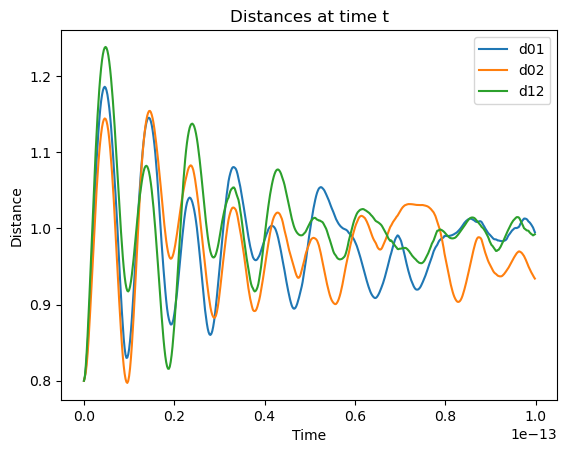

In [4]:
from matplotlib import pyplot as plt
(distance01,distance02,distance12,times) = main()

np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')
plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()